# Q1

In [1]:
import numpy as np
import pandas as pd
import os
from numpy import dtype
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt

from scipy import stats,signal
from datetime import date
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import glob
from scipy.stats import mannwhitneyu
import seaborn as sns

In [2]:
os.chdir("/data/keeling/a/junrenw2")

In [3]:
# read amm sst data
amm_sst_file = '/data/zhuowang/a/zhuowang/ATMS521/Data/AMM_sst.txt'
amm_sst = pd.read_csv(amm_sst_file, delim_whitespace=True, skiprows=5, index_col=0, header = None)
amm_sst = amm_sst.loc[range(1950,2016), range(7,11)]
# Calculate AMM index and find the positive and negative year
amm_sst = amm_sst.mean(axis = 1).to_frame()
amm_sst_mean = amm_sst.mean()
amm_sst_std = amm_sst.std()
amm_index = (amm_sst-amm_sst_mean)/amm_sst_std
posi = amm_index[0].sort_values(ascending=False).index[0:10].values
nega = amm_index[0].sort_values(ascending=True).index[0:10].values

#pos and neg  amm year
print("Positive:")
print(posi)
print("Negative:")
print(nega)

Positive:
[2010. 2005. 1958. 2004. 1955. 1995. 2012. 2013. 1952. 1998.]
Negative:
[1972. 1974. 1984. 1993. 1986. 1965. 1963. 1973. 1994. 1991.]


In [4]:
data_dir = '/data/zhuowang/b/shared/NNR/monthly/'
files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
for f in files:
    print(f)

vwnd.mon.mean.nc
ftp.log
hgt.mon.mean.nc
rhum.mon.mean.nc
cftp
uwnd.mon.mean.nc


In [5]:
# read 600-hPa relative humidity
rhum_file = f'{data_dir}/rhum.mon.mean.nc'
rhum = xr.open_dataset(rhum_file).sel(level=600, lat=slice(75, 0), lon=slice(360-100, 360-10))

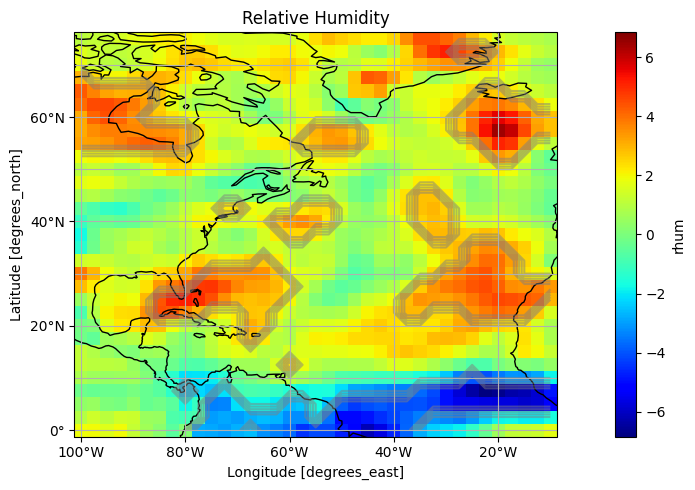

In [6]:
rhum_posi = rhum['rhum'].sel(time=rhum.time.dt.year.isin(posi))
rhum_posi = rhum_posi.sel(time=(rhum_posi.time.dt.month >= 7) & (rhum_posi.time.dt.month  <= 10))
rhum_nega = rhum['rhum'].sel(time=rhum.time.dt.year.isin(nega))
rhum_nega = rhum_nega.sel(time=(rhum_nega.time.dt.month >= 7) & (rhum_nega.time.dt.month  <= 10))
rhum_posi_composite_mean = rhum_posi.mean('time')
rhum_nega_composite_mean = rhum_nega.mean('time')
rhum_composite_mean_difference = rhum_posi_composite_mean-rhum_nega_composite_mean
fig, ax = plt.subplots(1, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
rhum_composite_mean_difference.plot(ax = ax, cmap='jet')
# Perform the t-test
t_stat, p_value = ttest_ind(rhum_posi, rhum_nega, equal_var=True)
spy1 = np.where(p_value < 0.05, 1, 0)
sig = xr.DataArray(data=spy1, dims=["lat", "lon"], coords=[rhum_composite_mean_difference.lat,rhum_composite_mean_difference.lon])
sig.plot.contour(ax = ax,colors = 'grey', alpha = 0.5)
ax.coastlines()
ax.gridlines()
xticks = range(-100, -10, 20)
yticks = range(0, 75, 20)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# set the latitude and longitude tick labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax.set_title("Relative Humidity")
plt.tight_layout()
plt.show()

In [7]:
# read wind sheer data
u_file = f'{data_dir}/uwnd.mon.mean.nc'
u_850 = xr.open_dataset(u_file).sel(time=slice('1950-01', '2015-12'), level=850, lat=slice(75, 0), lon=slice(360-100, 360-10))['uwnd']
u_200 = xr.open_dataset(u_file).sel(time=slice('1950-01', '2015-12'), level=200, lat=slice(75, 0), lon=slice(360-100, 360-10))['uwnd']
v_file = f'{data_dir}/vwnd.mon.mean.nc'
v_850 = xr.open_dataset(v_file).sel(time=slice('1950-01', '2015-12'), level=850, lat=slice(75, 0), lon=slice(360-100, 360-10))['vwnd']
v_200 = xr.open_dataset(v_file).sel(time=slice('1950-01', '2015-12'), level=200, lat=slice(75, 0), lon=slice(360-100, 360-10))['vwnd']
vws = np.sqrt((u_200-u_850)**2 +(v_200-v_850)**2)



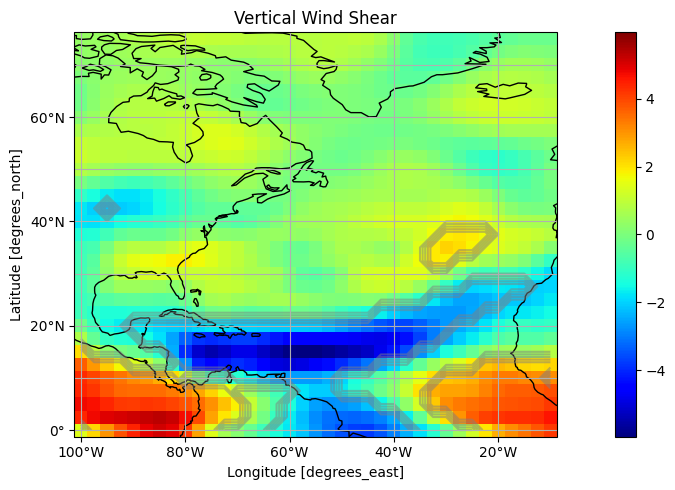

In [8]:
vws_posi = vws.sel(time=vws.time.dt.year.isin(posi))
vws_posi = vws_posi.sel(time=(vws_posi.time.dt.month >= 7) & (vws_posi.time.dt.month  <= 10))
vws_nega =vws.sel(time=vws.time.dt.year.isin(nega))
vws_nega = vws_nega.sel(time=(vws_nega.time.dt.month >= 7) & (vws_nega.time.dt.month  <= 10))
vws_posi_composite_mean = vws_posi.mean('time')
vws_nega_composite_mean = vws_nega.mean('time')
vws_composite_mean_difference = vws_posi_composite_mean-vws_nega_composite_mean
fig, ax = plt.subplots(1, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
vws_composite_mean_difference.plot(ax = ax, cmap='jet')
# Perform the t-test
t_stat, p_value = ttest_ind(vws_posi, vws_nega, equal_var=True)
spy1 = np.where(p_value < 0.05, 1, 0)
sig = xr.DataArray(data=spy1, dims=["lat", "lon"], coords=[vws_composite_mean_difference.lat,vws_composite_mean_difference.lon])
sig.plot.contour(ax = ax,colors = 'grey', alpha = 0.5)
ax.coastlines()
ax.gridlines()
xticks = range(-100, -10, 20)
yticks = range(0, 75, 20)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# set the latitude and longitude tick labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax.set_title("Vertical Wind Shear")
plt.tight_layout()
plt.show()

# Q2

In [9]:
# Load SST data and define predictor variables
sst_file = '/data/zhuowang/b/shared/ERSST_v4/sst.mnmean.v4.nc'
sst = xr.open_dataset(sst_file)['sst']

In [10]:
sst_d1 = sst.sel(lat=slice(60, 50), lon=slice(360-60, 360-30),time=sst['time.month'].isin([4,5,6]))
sst_d1 = sst_d1.sel(time = slice('1950', '2013'))
sst_d1 = sst_d1.mean(dim=['lat', 'lon'])
sst_d1_reshaped = np.reshape(sst_d1.values, (64, 3))
sst_d1_df = pd.DataFrame(sst_d1_reshaped).sum(axis = 1).to_frame()
sst_d1_df.columns = ["x1"]
sst_d1_df.index = range(1950, 2014)


In [11]:
sst_d2 = sst.sel(lat=slice(50, 45), lon=slice(170, 190),time=sst['time.month'].isin([4,5,6]))
sst_d2 = sst_d2.sel(time = slice('1950', '2013'))
sst_d2 = sst_d2.mean(dim=['lat', 'lon'])
sst_d2_reshaped = np.reshape(sst_d2.values, (64, 3))
sst_d2_df = pd.DataFrame(sst_d2_reshaped).sum(axis = 1).to_frame()
sst_d2_df.columns = ["x2"]
sst_d2_df.index = range(1950, 2014)


In [12]:
sst_d3 = sst.sel(lat=slice(35, 25), lon=slice(135, 185),time=sst['time.month'].isin([4,5,6]))
sst_d3 = sst_d3.sel(time = slice('1950', '2013'))
sst_d3 = sst_d3.mean(dim=['lat', 'lon'])
sst_d3_reshaped = np.reshape(sst_d3.values, (64, 3))
sst_d3_df = pd.DataFrame(sst_d3_reshaped).sum(axis = 1).to_frame()
sst_d3_df.columns = ["x3"]
sst_d3_df.index = range(1950, 2014)


In [13]:
hurricane_file = "/data/zhuowang/a/zhuowang/ATMS521/Data/Hurricane_AT.txt"
hurricane = pd.read_csv(hurricane_file, delim_whitespace=True, index_col=0,skiprows=1,  header = None)
hurricane = hurricane.loc[range(1950,2014), range(7,11)].sum(axis=1).to_frame()
hurricane.columns = ["JASOcount"]

In [14]:
df = hurricane.merge(sst_d1_df, left_index = True, right_index = True).merge(sst_d2_df, left_index = True, right_index = True).merge(sst_d3_df, left_index = True, right_index = True)
df

,JASOcount,x1,x2,x3
0,,,,
1950,11,15.322687,15.279697,67.095917
1951,5,17.809464,16.271212,65.917206
1952,6,16.789032,16.334848,67.107681
1953,5,17.823763,15.236667,65.324554
1954,5,16.094624,15.295152,65.953354
...,...,...,...,...
2009,2,16.668711,18.260303,66.350723
2010,11,19.747526,15.100605,66.114716
2011,7,17.851292,16.973331,66.017761


In [15]:
def lv1out_possion(x0,y0):
    ys=np.zeros(len(y0))
    for i in range(len(y0)):
        x1=x0[i,:]          #testing data point
        x=np.delete(x0,i,axis=0) #construct the training dataset
        y=np.delete(y0,i,axis=0)
        #estimate discretemod.Poisson 
        model1=Poisson(y, x).fit()
        #reg.predict expects 2D array. array.reshape(1,-1) is used to reshape x1
        y1=model1.predict(x1.reshape(1, -1))  #predict y for the testing point
        ys[i]=y1[:]         #ys is the predicted time series of the predictand
    return ys
y_hat = lv1out_possion(df[["x1","x2", "x3"]].to_numpy(), df[["JASOcount"]].to_numpy() )


Optimization terminated successfully.
         Current function value: 2.147789
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.188745
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.190071
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.184940
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.190674
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.181663
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.191576
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.185594
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.188779
         Iterations 11
Optimization terminated successfully.
         Current function value: 2.

In [16]:
# Compute the rank correlation
rho, p_value = spearmanr(df[["JASOcount"]].to_numpy(), y_hat)

# Show the rank correlation coefficient and p-value
print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.48219426387814796
P-value: 5.468687593608917e-05


In [17]:
#calculate rmse
rmse = np.sqrt(np.mean((df[["JASOcount"]].to_numpy() - y_hat) ** 2))
# Show the RMSE
print(f"RMSE: {rmse}")

RMSE: 3.082852762016885


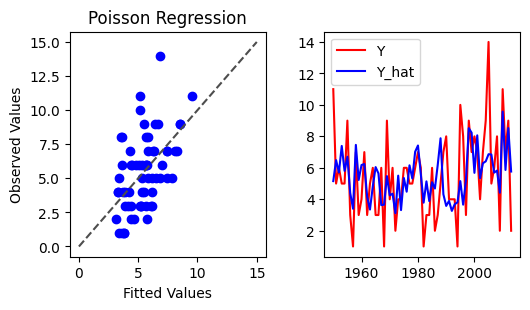

In [18]:
f, axs = plt.subplots(1,2,figsize=(6,3))
axs[0].scatter(y_hat,df[["JASOcount"]].to_numpy(),c='b')
#add a diagonal line
axs[0].plot([0,15],[0,15],ls="--", c=".3")
axs[0].set_xlabel('Fitted Values')
axs[0].set_ylabel('Observed Values')
axs[0].set_title('Poisson Regression')
axs[1].plot(df[["JASOcount"]].index.values,df[["JASOcount"]].to_numpy(),c='r', label = "Y")
axs[1].plot(df[["JASOcount"]].index.values,y_hat,c='b',label = "Y_hat")
axs[1].legend()
plt.subplots_adjust(top=0.90,bottom=0.15,left=0.15,right=0.9,hspace=0.35,wspace=0.3)
fmt="png"
plt.show(block=False)


# Q3
The input data were downloaded from the CMIP6 datasets; the wget files used to download the model output is save in "/data/keeling/a/junrenw2/a/wget-*.sh" The download data were saved in "/data/keeling/a/junrenw2/a" folder

We combined the data using the following code; only need to run one time and the combined datasets were saved in"/data/keeling/a/junrenw2/b" folder

In [19]:
## combine files 
# model_set = ["ACCESS-CM2", "ACCESS-ESM1-5","AWI-CM-1-1-MR","BCC-CSM2-MR","CAMS-CSM1-0","CAS-ESM2-0",\
#              "CESM2","CESM2-WACCM","CanESM5-CanOE","EC-Earth3-CC","EC-Earth3-Veg","EC-Earth3-Veg-LR",\
#             "FGOALS-f3-L","FGOALS-g3",
#               "GFDL-CM4","IPSL-CM6A-LR","MCM-UA-1-0", "MIROC6","MIROC-ES2L",\
#             "MPI-ESM1-2-HR","MPI-ESM1-2-LR","MRI-ESM2-0"]
# for i in model_set:
#     for j in ["tas","pr"]:
#         files =  glob.glob("a/"+j+"*"+i+"_"+"*.nc")
#         files.sort()
#         tmp1 = xr.open_dataset(files[0])
#         if len(files)>1:
#             for file in files[1:]:
#                 tmp2 = xr.open_dataset(file)
#                 # Combine the two datasets along the time dimension
#                 combined_data = xr.concat([tmp1, tmp2], dim='time')
#                 tmp1 = combined_data
#             # Save the combined dataset to a new NetCDF file
#         else:
#             combined_data = tmp1.copy()
#         combined_data.to_netcdf("b/"+j+"_"+i+"_combined.nc")

(1) Calculate the June-August seasonal mean surface air temperature from 1949 to 2099
averaged over the US Great Plain (30-50N, 95-110W) from each model, and plot the
time series of the multi-model ensemble mean surface air temperature from 1949-2099
along with the 10-90% percentile

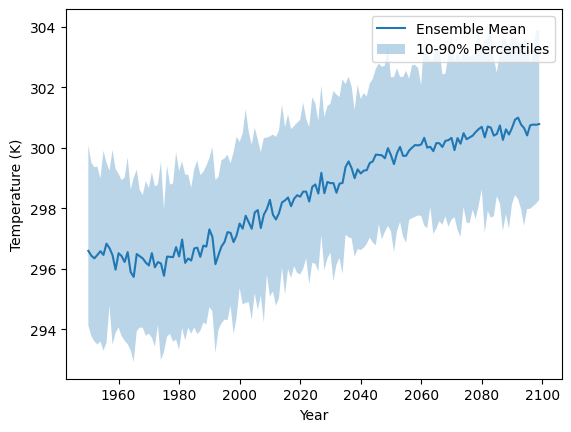

In [20]:
# open netCDF files for temperature
temp_files = glob.glob("b/tas*_combined.nc")

# create an empty list to store temperature data for each model
temp_data = []

# loop over the files and extract the temperature data for the US Great Plains
for file in temp_files:
    ds = xr.open_dataset(file)['tas']
    try: 
        ds =ds.drop('height')
    except:
        True
    try:
        # Rename the latitude and longitude coordinates
        ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    except:
        True
    try:
        temp = ds.sel(time = slice('1950','2099'), lat=slice(30, 50), lon=slice(360-110, 360-95))
        temp = temp.sel(time=temp['time.season']=='JJA')
        if temp.indexes['time'].dtype != '<M8[ns]':
                    # Get the time variable as a CFTimeIndex object
            time = temp.time.values.astype('datetime64[ns]')

            temp = temp.assign_coords(time=time)

        temp = temp.groupby('time.year').mean(dim='time').mean(dim=['lat', 'lon'])
        temp_data.append(temp)
    except:
        print(file)
# calculate the multi-model ensemble mean temperature and 10-90% percentile
temp_data = xr.concat(temp_data, dim='model')
temp_ensemble_mean = temp_data.mean(dim='model')
temp_ensemble_percentiles = np.nanpercentile(temp_data, [10, 90], axis=0)

# plot the time series of temperature along with the percentiles
plt.plot(range(1950, 2100), temp_ensemble_mean, label='Ensemble Mean')
plt.fill_between(range(1950, 2100), temp_ensemble_percentiles[0], temp_ensemble_percentiles[1], alpha=0.3, label='10-90% Percentiles')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

(2) Repeat the above analysis for the June-August seasonal mean precipitation averaged
over the US Great Plain

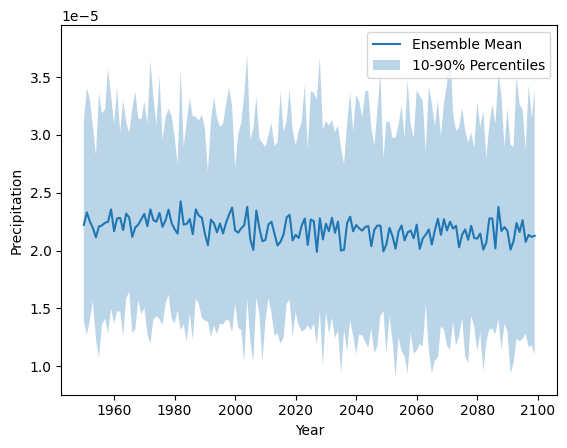

In [21]:
# open netCDF files for precipitation
precip_files = glob.glob("b/pr*_combined.nc")

# create an empty list to store precipitation data for each model
precip_data = []

# loop over the files and extract the precipitation data for the US Great Plains
for file in precip_files:
    ds = xr.open_dataset(file)['pr']
    try: 
        ds =ds.drop('height')
    except:
        True
    try:
        # Rename the latitude and longitude coordinates
        ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    except:
        True
    precip = ds.sel(time = slice('1950','2099'), lat=slice(30, 50), lon=slice(360-110, 360-95))
    precip = precip.sel(time=precip['time.season']=='JJA')

    if precip.indexes['time'].dtype != '<M8[ns]':
                # Get the time variable as a CFTimeIndex object
        time = precip.time.values.astype('datetime64[ns]')

        precip = precip.assign_coords(time=time)

    precip = precip.groupby('time.year').mean(dim='time').mean(dim=['lat', 'lon'])
    precip_data.append(precip)

# calculate the multi-model ensemble mean precipitation and 10-90% percentile
precip_data = xr.concat(precip_data, dim='model')
precip_ensemble_mean = precip_data.mean(dim='model')
precip_ensemble_percentiles = np.nanpercentile(precip_data, [10, 90], axis=0)

# plot the time series of precipitation along with the percentiles
plt.plot(range(1950, 2100), precip_ensemble_mean, label='Ensemble Mean')
plt.fill_between(range(1950, 2100), precip_ensemble_percentiles[0], precip_ensemble_percentiles[1], alpha=0.3, label='10-90% Percentiles')
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

(3) (4)Construct and plot the probability distribution function of seasonal mean temperature
during June-August averaged over the US Great Plain for the following two time periods
using the GFDL-CM4 model output.
o historical time period 1949-1999
o future climate period 2049-2099

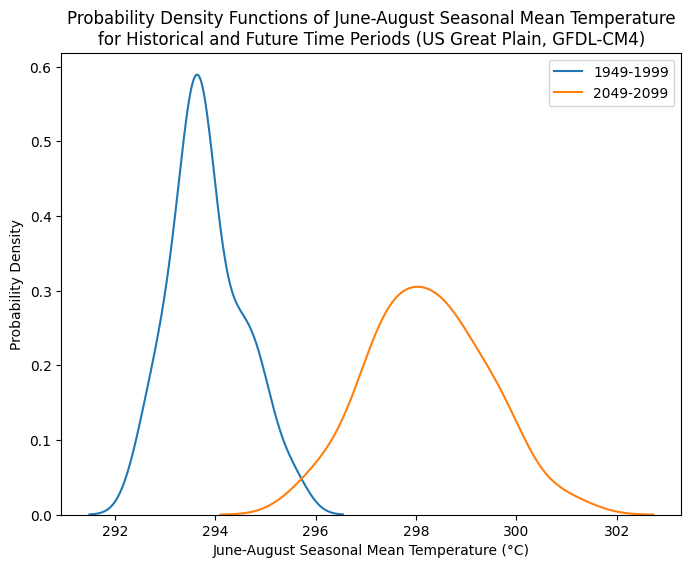

In [22]:

# Load the GFDL-CM4 temperature data
ds = xr.open_dataset('b/tas_GFDL-CM4_combined.nc')

# Select the temperature data for the US Great Plain region
temp = ds['tas'].sel(lat=slice(30, 50), lon=slice(360-110, 360-95))
time = temp.time.values.astype('datetime64[ns]')
temp = temp.assign_coords(time=time)
# Calculate the June-August seasonal mean temperature for each year in the historical time period
hist_temp = temp.sel(time=slice('1949', '1999'))
hist_temp = hist_temp.sel(time=hist_temp['time.season']=='JJA')
hist_temp = hist_temp.groupby('time.year').mean(dim='time').mean(dim=['lat', 'lon'])

# Calculate the June-August seasonal mean temperature for each year in the future climate period


future_temp = temp.sel(time=slice('2049', '2099'))
future_temp = future_temp.sel(time=future_temp['time.season']=='JJA')
future_temp = future_temp.groupby('time.year').mean(dim='time').mean(dim=['lat', 'lon'])


# Plot the probability density functions of the seasonal mean temperature for each time period
fig, ax = plt.subplots(figsize=(8, 6))
# Create a joint kernel density estimate plot for the two time periods
sns.kdeplot(hist_temp, label='1949-1999', ax = ax)
sns.kdeplot(future_temp, label='2049-2099', ax = ax)

# Add a legend to the plot
ax.legend()

# Add axis labels and a title
ax.set_xlabel('June-August Seasonal Mean Temperature (°C)')
ax.set_ylabel('Probability Density')
ax.set_title('Probability Density Functions of June-August Seasonal Mean Temperature\nfor Historical and Future Time Periods (US Great Plain, GFDL-CM4)')

plt.show()

In [23]:
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(hist_temp, future_temp)

# Print the results
print("Mann-Whitney U test results:")
print("Statistic:", statistic)
print("p-value:", p_value)


Mann-Whitney U test results:
Statistic: 0.0
p-value: 3.3036815016661564e-18
